# RecogNYCe - Dataset Scraping

In this notebook, the dataset for the RecogNYCe project is scraped, processed and organized.

We start from a geojson-description of New York City's boroughs, which is sampled using a monte-carlo sampling technique.  
As such, we create a collection of coordinates which are uniformly distributed across the areas of interest.  

Next, these coordinates are used to scrape two different street-level image sources: Google Maps and Mapillary.  
Images are requested from these sources in a radius of 50 meters around our point of interest.  
If an image is not available at the requested point, the coordinate is dropped.

Finally, all images are processed (cropped and scaled) to a 640x640 resolution, which is the maximum that can be requested through the google street view API.

A subset of the full dataset is exported for use in the webapp minigame.

The resulting dataset is available [here](https://drive.google.com/file/d/1uf4-sjmTlpDPRc4nTaanUCLmzOH8y1C9/view?usp=sharing).


Sources:
- NYC location data
  - [Boroughs geojson](./data/location/nyc_boroughs.geojson) - [source](https://github.com/codeforgermany/click_that_hood/blob/main/public/data/new-york-city-boroughs.geojson)
  - [Neighborhoods geojson](./data/location/nyc_neighborhoods.geojson) - [source](https://github.com/veltman/snd3/blob/master/data/nyc-neighborhoods.geo.json)
- NYC street-level image data
  - [Mapillary](https://www.mapillary.com/)
  - [Google Street View](https://www.google.com/streetview/)


In [1]:
# !pip install shapely
# !pip install geopandas
# !pip install aiohttp
# !pip install aiofiles
# !pip install opencv-python
#!pip install numpy
#!pip install pandas
#!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import shapely
import pandas as pd
import geopandas as gpd
import cv2
from utils.geojson_utils import Neighborhoods

### Location Data Exploration

Loading boroughs
len(nb.neighborhoods) = 5
Plotting boroughs


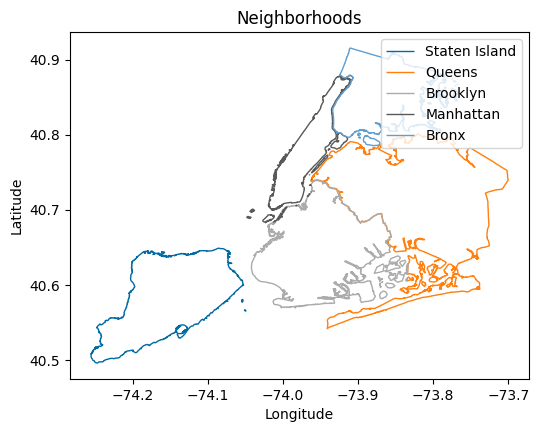

Sampling boroughs
Plotting samples


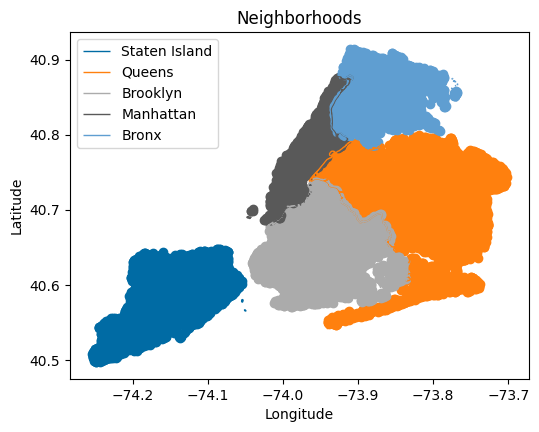

In [14]:
location_dir = "./data/location/"
geo_file = "nyc_boroughs.geojson"
geo_path = os.path.join(location_dir, geo_file)

# Load geojson file
print("Loading boroughs")
nb = Neighborhoods()
nb.load_geojson(geo_path)

print(f"{len(nb.neighborhoods) = }")

# Plot zones
print("Plotting boroughs")
ax = nb.plot()
ax.legend()
plt.show()

# Sample coordinates in neighborhoods
print("Sampling boroughs")
samples = nb.generate_samples(n_points=50000)

# Plot samples
print("Plotting samples")
ax = nb.plot()
ax.legend()
plt.show()

### Scraping street-level image data from coordinates

#### Mapillary

In [4]:
ran = False
from utils.mapillary_utils import download_images_async

In [7]:
assert not ran, "We should really only run this once for each selection of coordinates"

data_dir = "./data/mapillary"
csv_path = os.path.join(data_dir, "data.csv")
append_first = True
radius=50

for i, (neighborhood, coords) in enumerate(zip(nb.neighborhood_names, nb.neighborhood_samples)):
    print(f"Downloading images for {neighborhood} - trying {len(coords)} coordinates")
    results = await download_images_async(coords, neighborhood, data_dir=data_dir, radius=radius, verbose=False)
    append_results = i > 0 or append_first
    results.to_csv(csv_path, index=False, header=not append_results, mode="a" if append_results else "w")
    print(f"Downloaded {len(results)} images")

Downloaded 1087 images
Downloaded 4104 images
Downloaded 2402 images
Downloaded 1829 images
Downloaded 1419 images


In [12]:
# Load dataset
data_dir = "./data/mapillary"
csv_path = os.path.join(data_dir, "data.csv")
dataset = pd.read_csv(csv_path)
print(f"{len(dataset) = }")
dataset.head(10)

len(dataset) = 22275


,id,longitude,latitude,path,url,borough
0,362372405549249,-74.190323,40.551648,./data/mapillary/Staten Island/362372405549249...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
1,377744433572191,-74.142526,40.639040,./data/mapillary/Staten Island/377744433572191...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
2,586685652304410,-74.179546,40.626955,./data/mapillary/Staten Island/586685652304410...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
3,1872619506230640,-74.117018,40.615104,./data/mapillary/Staten Island/187261950623064...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
4,545737009753366,-74.183586,40.628516,./data/mapillary/Staten Island/545737009753366...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
5,604638233850121,-74.097429,40.574680,./data/mapillary/Staten Island/604638233850121...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
6,4247027342002516,-74.107719,40.619619,./data/mapillary/Staten Island/424702734200251...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
7,818751412382739,-74.157218,40.612331,./data/mapillary/Staten Island/818751412382739...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
8,527717428603442,-74.119584,40.565845,./data/mapillary/Staten Island/527717428603442...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island
9,1078417622686437,-74.062989,40.606237,./data/mapillary/Staten Island/107841762268643...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island


Staten Island - 2316
Queens - 8419
Brooklyn - 4939
Manhattan - 3719
Bronx - 2882


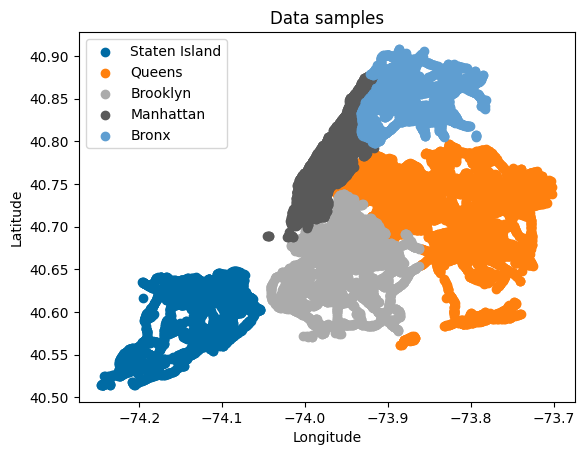

In [13]:
fig, ax = plt.subplots()
boroughs = dataset["borough"].unique()
for i, borough in enumerate(boroughs):
    borough_set = dataset[dataset["borough"] == borough]
    print(f"{borough} - {len(borough_set)}")
    lon = borough_set["longitude"].to_numpy()
    lat = borough_set["latitude"].to_numpy()
    ax.scatter(lon, lat, c=f"C{i}", label=borough)
ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Data samples")
plt.show()

#### Google Street View

I am guessing the data will be way higher quality for this.  
It costs money though (see [here](https://developers.google.com/maps/documentation/streetview/usage-and-billing)).  
If we pick 1000 locations per one of the 5 boroughs, it should only be 25$ (and new accounts have 300$ credit so it should be fine).

In [15]:
ran = False
from utils.gmaps_utils import download_images_async

In [16]:
assert not ran, "We should really only run this once for each selection of coordinates"

data_dir = "./data/gmaps"
csv_path = os.path.join(data_dir, "data.csv")
append_first = True
radius=50

for i, (neighborhood, coords) in enumerate(zip(nb.neighborhood_names, nb.neighborhood_samples)):
    print(f"Downloading images for {neighborhood} - trying {len(coords)} coordinates")
    results = await download_images_async(coords, neighborhood, data_dir=data_dir, radius=radius, verbose=False)
    append_results = i > 0 or append_first
    results.to_csv(csv_path, index=False, header=not append_results, mode="a" if append_results else "w")
    print(f"Downloaded {len(results)} images")

Downloaded 2288 images
Downloaded 5170 images
Downloaded 3563 images
Downloaded 1258 images
Downloaded 1953 images


In [36]:
# Load dataset
data_dir = "./data/gmaps"
csv_path = os.path.join(data_dir, "data.csv")
dataset = pd.read_csv(csv_path)
print(f"{len(dataset) = }")
dataset.head(10)

len(dataset) = 17258


,id,longitude,latitude,path,url,borough
0,776311812884181,-74.101624,40.631784,./data/gmaps/Staten Island/776311812884181.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
1,55572348879348,-74.146832,40.585820,./data/gmaps/Staten Island/55572348879348.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
2,687060702443724,-74.139624,40.556697,./data/gmaps/Staten Island/687060702443724.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
3,808665269835874,-74.188567,40.521038,./data/gmaps/Staten Island/808665269835874.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
4,678431601609258,-74.145368,40.613096,./data/gmaps/Staten Island/678431601609258.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
5,855504280525421,-74.125516,40.617743,./data/gmaps/Staten Island/855504280525421.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
6,494563815488500,-74.093276,40.571268,./data/gmaps/Staten Island/494563815488500.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
7,845875001551154,-74.220001,40.520076,./data/gmaps/Staten Island/845875001551154.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
8,853154045270008,-74.070525,40.605579,./data/gmaps/Staten Island/853154045270008.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island
9,874617728122530,-74.168442,40.618458,./data/gmaps/Staten Island/874617728122530.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island


Staten Island - 2806
Queens - 6274
Brooklyn - 4306
Manhattan - 1498
Bronx - 2374


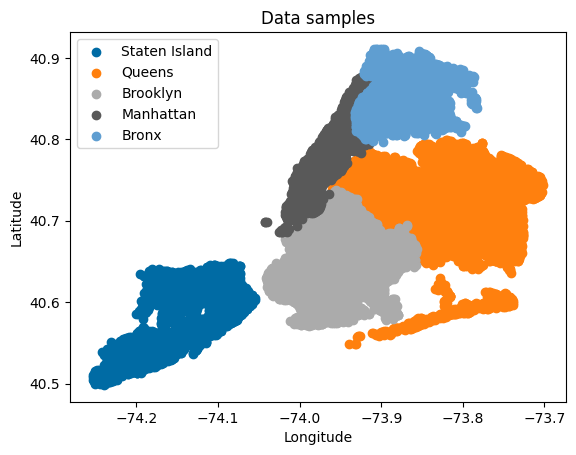

In [18]:
fig, ax = plt.subplots()
boroughs = dataset["borough"].unique()
for i, borough in enumerate(boroughs):
    borough_set = dataset[dataset["borough"] == borough]
    print(f"{borough} - {len(borough_set)}")
    lon = borough_set["longitude"].to_numpy()
    lat = borough_set["latitude"].to_numpy()
    ax.scatter(lon, lat, c=f"C{i}", label=borough)
ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Data samples")
plt.show()

### Joining the datasets

In [16]:
# Load datasets tables
gmaps_data_dir = "./data/gmaps"
gmaps_csv_path = os.path.join(gmaps_data_dir, "data.csv")
mapillary_data_dir = "./data/mapillary"
mapillary_csv_path = os.path.join(mapillary_data_dir, "data.csv")

gmaps_df = pd.read_csv(gmaps_csv_path)
mapillary_df = pd.read_csv(mapillary_csv_path)

In [17]:
# Add source
gmaps_df["source"] = "Google Maps"
gmaps_df.head()

,id,longitude,latitude,path,url,borough,source
0,776311812884181,-74.101624,40.631784,./data/gmaps/Staten Island/776311812884181.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island,Google Maps
1,55572348879348,-74.146832,40.585820,./data/gmaps/Staten Island/55572348879348.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island,Google Maps
2,687060702443724,-74.139624,40.556697,./data/gmaps/Staten Island/687060702443724.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island,Google Maps
3,808665269835874,-74.188567,40.521038,./data/gmaps/Staten Island/808665269835874.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island,Google Maps
4,678431601609258,-74.145368,40.613096,./data/gmaps/Staten Island/678431601609258.jpg,https://maps.googleapis.com/maps/api/streetvie...,Staten Island,Google Maps


In [18]:
# Add source
mapillary_df["source"] = "Mapillary"
mapillary_df.head()

,id,longitude,latitude,path,url,borough,source
0,362372405549249,-74.190323,40.551648,./data/mapillary/Staten Island/362372405549249...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
1,377744433572191,-74.142526,40.639040,./data/mapillary/Staten Island/377744433572191...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
2,586685652304410,-74.179546,40.626955,./data/mapillary/Staten Island/586685652304410...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
3,1872619506230640,-74.117018,40.615104,./data/mapillary/Staten Island/187261950623064...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
4,545737009753366,-74.183586,40.628516,./data/mapillary/Staten Island/545737009753366...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary


In [56]:
# Join dataframes
joint_df = pd.concat([mapillary_df, gmaps_df], ignore_index=True)
print(f"Total nr of samples = {len(joint_df)}")
joint_df.head()

Total nr of samples = 39533


,id,longitude,latitude,path,url,borough,source
0,362372405549249,-74.190323,40.551648,./data/mapillary/Staten Island/362372405549249...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
1,377744433572191,-74.142526,40.639040,./data/mapillary/Staten Island/377744433572191...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
2,586685652304410,-74.179546,40.626955,./data/mapillary/Staten Island/586685652304410...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
3,1872619506230640,-74.117018,40.615104,./data/mapillary/Staten Island/187261950623064...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
4,545737009753366,-74.183586,40.628516,./data/mapillary/Staten Island/545737009753366...,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary


Staten Island: 5122
Queens: 14693
Brooklyn: 9245
Manhattan: 5217
Bronx: 5256


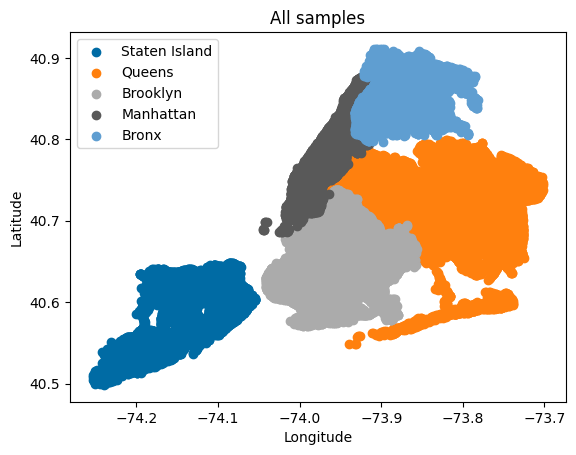

In [57]:
fig, ax = plt.subplots()
for borough in joint_df["borough"].unique():
    borough_df = joint_df[joint_df["borough"] == borough]
    print(f"{borough}: {len(borough_df)}")
    ax.scatter(borough_df["longitude"], borough_df["latitude"], label=borough)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("All samples")
ax.legend()
plt.show()

In [70]:
# Crop and scale all image uniformly
def process_img(img, crop=True, resolution=640):
    h, w, c = img.shape
    if h == resolution and w == resolution:
        return img
    d_min = min(h, w)
    img_cropped = img[(h-d_min)//2:(h+d_min)//2, (w-d_min)//2:(w+d_min)//2, :]
    img_scaled = cv2.resize(img_cropped, (resolution, resolution), interpolation= cv2.INTER_LINEAR)
    return img_scaled

# Make sure all borough dirs exist
data_dir = "./data/all"
for borough in joint_df["borough"].unique():
    borough_dir = os.path.join(data_dir, borough)
    os.makedirs(borough_dir, exist_ok=True)

# Move data 
out_df = joint_df.copy()
for i, row in joint_df.iterrows():
    # Figure out new path to store data
    old_path = os.path.join(row["path"])
    rel_path = os.sep.join(old_path.split(os.sep)[-2:])
    new_path = os.path.join(data_dir, rel_path)
    
    # Skip if the file doesn't exist
    if not os.path.exists(old_path):
        print(f"WARNING: img for path {old_path} does not exist")
        out_df = out_df.drop(i, axis="index")
        continue
    
    # Read, process & write image
    img = cv2.imread(old_path)
    img = process_img(img)
    success = cv2.imwrite(new_path, img)
    assert success, f"Unable to save image to {new_path}"

    # Update path in df
    out_df.at[i, "path"] = new_path

    # Update progress
    sys.stdout.write("\r")
    sys.stdout.write(f"Processing: {i / len(joint_df) * 100:.2f} %")
    sys.stdout.flush()

out_df = out_df.drop_duplicates(subset='id') # Make sure the dataset is unique
out_df.to_csv(os.path.join(data_dir, "data.csv"), index=False)

Processing: 100.00 %

In [67]:
out_df.head()

,id,longitude,latitude,path,url,borough,source
0,362372405549249,-74.190323,40.551648,./data/all/Staten Island/362372405549249.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
1,377744433572191,-74.142526,40.639040,./data/all/Staten Island/377744433572191.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
2,586685652304410,-74.179546,40.626955,./data/all/Staten Island/586685652304410.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
3,1872619506230640,-74.117018,40.615104,./data/all/Staten Island/1872619506230640.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary
4,545737009753366,-74.183586,40.628516,./data/all/Staten Island/545737009753366.jpg,https://scontent-lga3-1.xx.fbcdn.net/m1/v/t6/A...,Staten Island,Mapillary


### Dataset subset for the webapp

In [78]:
# Create a subset of the images for our webapp
subset_length = 1000

data_dir = "./data/all"
data_df = pd.read_csv(os.path.join(data_dir, "data.csv"))

webapp_df = data_df.sample(n=subset_length, random_state=12345)
webapp_df.to_csv(os.path.join(data_dir, "data_webapp.csv"), index=False)
